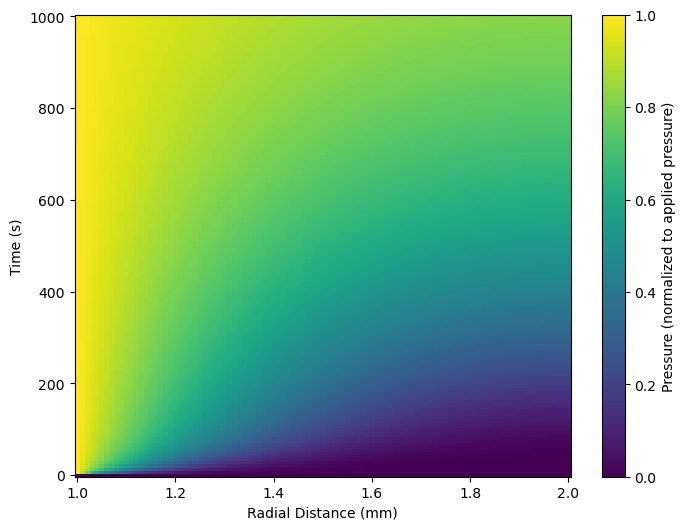

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Material and physical properties
K = 9e9       # Bulk modulus (Pa)
G = 3e9       # Shear modulus (Pa)
rho = 1000    # Fluid density (kg/m^3)
g = 9.81
alpha = 0.8   # Biot's coefficient
S = 1e-10     # Storage coefficient (1/Pa)
k = 1e-15     # Permeability (m^2)

# Domain parameters
a = 0.001     # Inner radius (m)
b = 0.002     # Outer radius (m)
N_r = 100     # Number of spatial grid points
N_t = 150     # Number of time steps
T = 1000.0    # Total simulation time (s)

# Derived parameters
gamma = rho*g
D = k / gamma # Hydraulic diffusivity (m^2/s)
A = K - (2/3)*G
B = K + (4/3)*G

# Spatial grid
R = np.linspace(a, b, N_r+1)
Delta_R = R[1] - R[0]

# Temporal grid
t = np.linspace(0, T, N_t+1)
Delta_t = t[1] - t[0]

# Initialize arrays to store solution fields at each timestep
u_all = np.zeros((N_t+1, N_r+1))         # Displacement
epsilon_all = np.zeros((N_t+1, N_r+1))   # Volumetric strain
p_all = np.zeros((N_t+1, N_r+1))         # Pressure

# Initial conditions
u_prev = np.zeros(N_r+1)
epsilon_prev = np.zeros(N_r+1)
p_prev = np.zeros(N_r+1)

# Store initial conditions
u_all[0, :] = u_prev
epsilon_all[0, :] = epsilon_prev
p_all[0, :] = p_prev

# Function for prescribed well pressure at R = a
def p_w(t):
    # Example: constant pressure
    return 1.0

# Effective radial stress boundary conditions
sigma_RR_prime_a = 0.0  # At R = a
sigma_RR_prime_b = 0.0  # At R = b

# Time-stepping loop
for n in range(N_t):
    # Time at current step
    t_n = t[n]
    t_np1 = t[n+1]
    
    # Total number of unknowns
    N_unknowns = 2 * (N_r + 1)
    
    # Initialize coefficient matrix and RHS vector
    A_matrix = np.zeros((N_unknowns, N_unknowns))
    d_vector = np.zeros(N_unknowns)
    
    # Assemble equations for each node
    for i in range(N_r+1):
        # Indices in the global system
        u_i = i                # Index for u_i^{n+1}
        p_i = N_r + 1 + i      # Index for p_i^{n+1}
        
        R_i = R[i]
        
        # Mechanical Equation
        if i == 0:
            # Boundary condition at R = a (sigma_RR_prime_a = 0)
            A_matrix[u_i, u_i] = (B / Delta_R) - (2 * A / R_i)
            A_matrix[u_i, u_i + 1] = -B / Delta_R
            d_vector[u_i] = sigma_RR_prime_a  # Zero in this case
        elif i == N_r:
            # Boundary condition at R = b (sigma_RR_prime_b = 0)
            A_matrix[u_i, u_i - 1] = -B / Delta_R
            A_matrix[u_i, u_i] = (B / Delta_R) + (2 * A / R_i)
            d_vector[u_i] = -sigma_RR_prime_b  # Zero in this case
        else:
            # Mechanical equilibrium equation
            a_u = (1 / Delta_R**2) + (1 / (R_i * Delta_R))
            b_u = -2 / Delta_R**2 + (2 / R_i**2)
            c_u = (1 / Delta_R**2) - (1 / (R_i * Delta_R))
            
            A_matrix[u_i, u_i - 1] = B * c_u
            A_matrix[u_i, u_i] = B * b_u - 2 * A / R_i**2
            A_matrix[u_i, u_i + 1] = B * a_u
            
            # Coupling with pressure gradient
            A_matrix[u_i, p_i + 1 - (N_r + 1)] = - (alpha / (2 * Delta_R))
            A_matrix[u_i, p_i - 1 - (N_r + 1)] = (alpha / (2 * Delta_R))
            
            d_vector[u_i] = 0.0  # No external body forces
            
        # Diffusion Equation
        if i == 0:
            # Pressure boundary condition at R = a
            A_matrix[p_i, p_i] = 1.0
            d_vector[p_i] = p_w(t_np1)
        elif i == N_r:
            # No-flow boundary condition at R = b
            A_matrix[p_i, p_i] = 1.0
            A_matrix[p_i, p_i - 1] = -1.0
            d_vector[p_i] = 0.0
        else:
            # Diffusion equation
            D_over_DeltaR2 = D / Delta_R**2
            D_over_Ri_DeltaR = D / (R_i * Delta_R)
            
            a_p = - D_over_DeltaR2 + D_over_Ri_DeltaR / 2
            b_p = S / Delta_t + 2 * D_over_DeltaR2
            c_p = - D_over_DeltaR2 - D_over_Ri_DeltaR / 2
            
            A_matrix[p_i, p_i - 1] = a_p
            A_matrix[p_i, p_i] = b_p
            A_matrix[p_i, p_i + 1] = c_p
            
            # Coupling with displacement (epsilon_i^{n+1})
            A_matrix[p_i, u_i - 1] = - (alpha / Delta_t) * (1 / (2 * Delta_R))
            A_matrix[p_i, u_i] = - (alpha / Delta_t) * (2 / R_i)
            A_matrix[p_i, u_i + 1] = - (alpha / Delta_t) * (1 / (2 * Delta_R))
            
            # Right-hand side
            d_vector[p_i] = (S / Delta_t) * p_prev[i] - (alpha / Delta_t) * epsilon_prev[i]
    
    # Solve the linear system
    solution = np.linalg.solve(A_matrix, d_vector)
    
    # Extract u and p from the solution vector
    u = solution[:N_r+1]
    p = solution[N_r+1:]
    
    # Compute epsilon at time n+1
    epsilon = np.zeros(N_r+1)
    epsilon[1:-1] = (u[2:] - u[:-2]) / (2 * Delta_R) + (2 * u[1:-1]) / R[1:-1]
    epsilon[0] = (u[1] - u[0]) / Delta_R + (2 * u[0]) / R[0]
    epsilon[-1] = (u[-1] - u[-2]) / Delta_R + (2 * u[-1]) / R[-1]
    
    # Update variables for next time step
    u_prev = u.copy()
    epsilon_prev = epsilon.copy()
    p_prev = p.copy()
    
    # Save the solution fields at this timestep
    u_all[n+1, :] = u
    epsilon_all[n+1, :] = epsilon
    p_all[n+1, :] = p

# Plotting the results
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(R*1e3, t, p_all, shading='auto')
plt.xlabel('Radial Distance (mm)')
plt.ylabel('Time (s)')
plt.colorbar(c, label='Pressure (normalized to applied pressure)')
plt.show()
